## Indexing

-- Multi Representation indexing:
First we generate a summary for a document using an LLM, and we store the document in a particular document DB. Then during retrieval we use the summary to retrieve the full document.


In [ ]:
! pip -q install langchain_community tiktoken langchain-deepseek langchainhub chromadb langchain_chroma langchain dotenv bs4 langchain-text-splitters langchain-ollama

In [ ]:
# Setup

import os
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
from langchain_deepseek import ChatDeepSeek

load_dotenv()

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

# Loading my LLM API Key

EMBEDDING_MODEL_NAME = "qwen3-embedding:0.6b"
DEEPSEEK_MODEL_NAME='deepseek-chat'

OLLAMA_EMBEDDING = OllamaEmbeddings(model=EMBEDDING_MODEL_NAME)
DEEPSEEK_LLM = ChatDeepSeek(model=DEEPSEEK_MODEL_NAME, temperature=0, api_key=os.getenv('DEEPSEEK_API_KEY'))


In [ ]:
## Loading

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader('https://lilianweng.github.io/posts/2023-06-23-agent/')
docs = loader.load()

loader = WebBaseLoader('https://lilianweng.github.io/posts/2024-02-05-human-data-quality/')
docs.extend(loader.load())


In [ ]:
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {'doc': lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | DEEPSEEK_LLM
    |StrOutputParser()
)

summaries = chain.batch(docs, {'max_concurrency': 5})

In [ ]:
summaries

In [ ]:
import uuid

from langchain_classic.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain_classic.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(collection_name="summaries", embedding_function= OLLAMA_EMBEDDING)

store = InMemoryByteStore()
id_key = 'doc_id'

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(summaries)
]

# Add 
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
query = "High quality annotated data"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

In [ ]:
retrieved_docs = retriever.invoke(query) # In the new version we no longer use get_relevant_document, rather we use invoke.
retrieved_docs[0].page_content

## Raptor

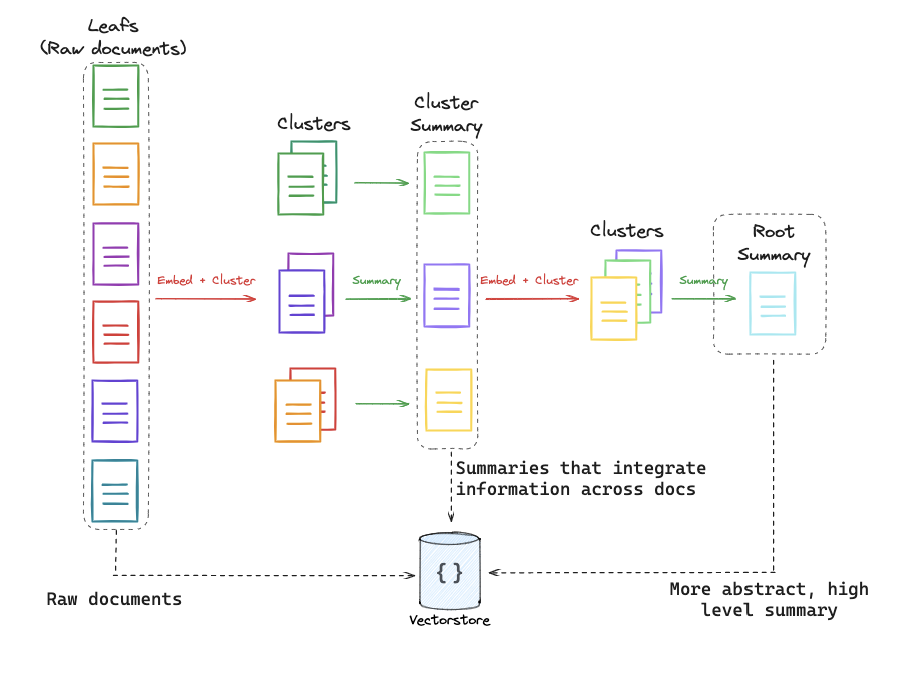

When do we use it:
- When we have a question that requires information that is collected from multiple documents in the corpus. (Often highlevel questions only)
> For Inv this seems to be a good thing for it.


In [ ]:
! pip -q install -U umap-learn scikit-learn langchainhub matplotlib

In [ ]:
# Loading documents

import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

def num_tokens_from_string(text: str, encoding_name: str) -> int:
    """
    Returns the number of tokens in a text string.
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_token = len(encoding.encode(text))
    return num_token

url = "https://python.langchain.com/docs/expression_language/"

loader = RecursiveUrlLoader(
    url=url,
    max_depth=20,
    extractor=lambda x: Soup(x, "html.parser").text
)

docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=1,
    extractor= lambda x: Soup(x, 'html.parser').text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=1,
    extractor= lambda x: Soup(x, 'html.parser').text
)

docs_sq = loader.load()

docs.extend([*docs_pydantic, *docs_sq])
docs_text = [d.page_content for d in docs]

counts = [num_tokens_from_string(d, 'cl100k_base') for d  in docs_text]

# Plotting on histogram:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="green", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show

In [ ]:
# Clustering

from typing import Dict, List, Optional, Tuple